In [1]:
import logging

logging.basicConfig(
    level="INFO", format="%(asctime)s %(message)s", datefmt="%d-%b-%y %H:%M:%S"
)


In [3]:
import numpy as np

from src.load_data import load_data
from src.parameters import SAMPLING_FREQUENCY


animal, date = "IM-1478", "07252022"

(position_info, spikes, multiunit_firing_rate, multiunit_HSE_times) = load_data(
    position_file_name=f"../Raw-Data/{date}/{animal}_{date}_position.csv",
    spike_file_name=f"../Raw-Data/{date}/{animal}_{date}_spikesWithPosition.csv")

# cut out first 20 s because animal is being placed on track
start_ind = int(20.0 * SAMPLING_FREQUENCY)
position_info = position_info.iloc[start_ind:]
spikes = spikes.iloc[start_ind:]
multiunit_firing_rate = multiunit_firing_rate.iloc[start_ind:]

# Fix particularly bad jump in position
time_slice = slice(864_080, 864_150)
position_info.iloc[time_slice, [1, 2, 5]] = np.nan
position_info = position_info.interpolate()

# Save
position_info.to_csv(f"../Processed-Data/{animal}_{date}_position_info.csv")
spikes.to_csv(f"../Processed-Data/{animal}_{date}_spikes.csv")
multiunit_firing_rate.to_csv(f"../Processed-Data/{animal}_{date}_multiunit_firing_rate.csv")
multiunit_HSE_times.to_csv(f"../Processed-Data/{animal}_{date}_multiunit_HSE_times.csv")

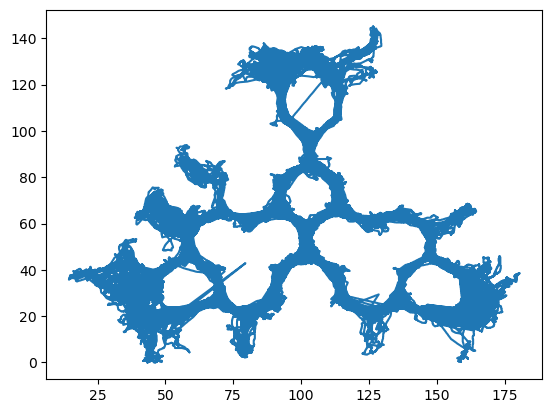

In [4]:
import matplotlib.pyplot as plt

plt.plot(position_info.x, position_info.y)


<Axes: >

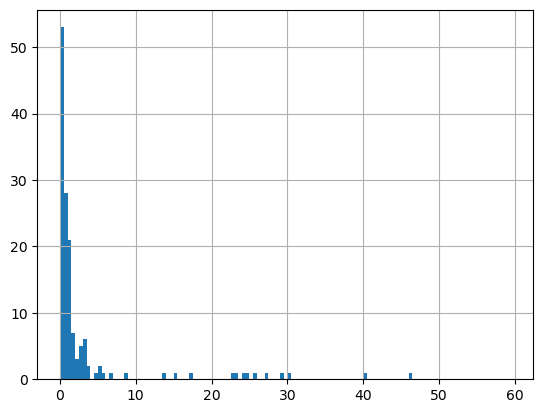

In [5]:
import numpy as np


(spikes.mean() * SAMPLING_FREQUENCY).hist(bins=np.arange(0, 60, 0.5))

In [52]:
from replay_trajectory_classification import (
    SortedSpikesClassifier,
    Environment,
    RandomWalk,
    Uniform,
)


environment = Environment(place_bin_size=2.0)
continuous_transition_types = [
    [RandomWalk(movement_var=12.0), Uniform()],
    [Uniform(), Uniform()],
]


classifier = SortedSpikesClassifier(
    environments=environment,
    continuous_transition_types=continuous_transition_types,
    sorted_spikes_algorithm="spiking_likelihood_kde_gpu",
    sorted_spikes_algorithm_params={
        "position_std": 6.0,
        "use_diffusion": False,
        "block_size": int(2**12),
    },
)

classifier


/home/edeno/miniconda3/envs/tk_decoding/lib/python3.10/site-packages/replay_trajectory_classification/likelihoods/multiunit_likelihood.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


SortedSpikesClassifier(continuous_transition_types=[[RandomWalk(environment_name='',
                                                                movement_var=12.0,
                                                                movement_mean=0.0,
                                                                use_diffusion=False),
                                                     Uniform(environment_name='',
                                                             environment2_name=None)],
                                                    [Uniform(environment_name='',
                                                             environment2_name=None),
                                                     Uniform(environment_name='',
                                                             environment2_name=None)]],
                       discrete_transition_type=DiagonalDiscrete(diagona...
                       infer_track_interior=True,
                       initial_conditions_type=UniformInitialConditions(),
                       observation_models=(ObservationModel(environment_name='',
                                                            encoding_group=0),
                                           ObservationModel(environment_name='',
                                                            encoding_group=0)),
                       sorted_spikes_algorithm='spiking_likelihood_kde_gpu',
                       sorted_spikes_algorithm_params={'block_size': 4096,
                                                       'position_std': 6.0,
                                                       'use_diffusion': False})

In [53]:
import cupy as cp
import xarray as xr


state_names = ["continuous", "fragmented"]

GPU_ID = 0

n_time = len(spikes)
n_segments = 2

results = []

# use context manager to specify which GPU (device)
with cp.cuda.Device(GPU_ID):
    # Fit the place fields
    classifier.fit(
        position=position_info[["x", "y"]],
        spikes=spikes,
    )

    for ind in range(n_segments):
        time_slice = slice(ind * n_time // n_segments, (ind + 1) * n_time // n_segments)
        results.append(
            classifier.predict(
                spikes.iloc[time_slice],
                time=spikes.iloc[time_slice].index.to_numpy(),
                state_names=state_names,
                use_gpu=True,
            )
        )
    logging.info("Done!")

results = xr.concat(results, dim="time")
results


18-Mar-23 06:14:12 Fitting initial conditions...
18-Mar-23 06:14:12 Fitting continuous state transition...
/home/edeno/miniconda3/envs/tk_decoding/lib/python3.10/site-packages/replay_trajectory_classification/continuous_state_transitions.py:23: RuntimeWarning: invalid value encountered in divide
  x /= x.sum(axis=1, keepdims=True)
18-Mar-23 06:14:16 Fitting discrete state transition
18-Mar-23 06:14:16 Fitting place fields...


  0%|          | 0/145 [00:00<?, ?it/s]

/home/edeno/miniconda3/envs/tk_decoding/lib/python3.10/site-packages/replay_trajectory_classification/likelihoods/spiking_likelihood_kde_gpu.py:115: RuntimeWarning: divide by zero encountered in log
  np.log(mean_rate) + np.log(marginal_density) - np.log(occupancy)
/home/edeno/miniconda3/envs/tk_decoding/lib/python3.10/site-packages/replay_trajectory_classification/likelihoods/spiking_likelihood_kde_gpu.py:115: RuntimeWarning: invalid value encountered in subtract
  np.log(mean_rate) + np.log(marginal_density) - np.log(occupancy)
18-Mar-23 06:15:50 Estimating likelihood...


  0%|          | 0/145 [00:00<?, ?it/s]

18-Mar-23 06:17:50 Estimating causal posterior...
18-Mar-23 06:20:43 Estimating acausal posterior...
18-Mar-23 06:31:27 Estimating likelihood...


  0%|          | 0/145 [00:00<?, ?it/s]

18-Mar-23 06:33:29 Estimating causal posterior...
18-Mar-23 06:36:20 Estimating acausal posterior...
18-Mar-23 06:47:12 Estimating likelihood...


  0%|          | 0/145 [00:00<?, ?it/s]

18-Mar-23 06:49:12 Estimating causal posterior...
18-Mar-23 06:52:03 Estimating acausal posterior...
18-Mar-23 07:02:51 Done!


<xarray.Dataset>
Dimensions:            (time: 1265995, state: 2, x_position: 86, y_position: 75)
Coordinates:
  * time               (time) float64 140.8 140.8 140.8 ... 5.205e+03 5.205e+03
  * x_position         (x_position) float64 13.47 15.45 17.42 ... 179.6 181.6
  * y_position         (y_position) float64 -0.9937 0.9937 2.981 ... 144.1 146.1
  * state              (state) <U10 'continuous' 'fragmented'
Data variables:
    likelihood         (time, state, x_position, y_position) float32 nan ... nan
    causal_posterior   (time, state, x_position, y_position) float32 nan ... nan
    acausal_posterior  (time, state, x_position, y_position) float32 nan ... nan
Attributes:
    data_log_likelihood:  -352011.75

In [ ]:
from src.analysis import compute_posterior_statistics

(
    most_probable_decoded_position,
    decode_distance_to_animal,
    hpd_spatial_coverage,
) = compute_posterior_statistics(
    position_info, classifier, results, hpd_coverage=0.95
)
results["most_probable_decoded_position"] = (["time", "position"], most_probable_decoded_position)
results["decode_distance_to_animal"] = ("time", decode_distance_to_animal)
results["hpd_spatial_coverage"] = ("time", np.asarray(hpd_spatial_coverage))

results

/home/edeno/miniconda3/envs/tk_decoding/lib/python3.10/site-packages/xarray/core/computation.py:760: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


In [74]:
results.drop(["likelihood", "causal_posterior"]).to_netcdf(
    f"../Processed-Data/{animal}_{date}_results.nc"
)


In [57]:
classifier.save_model(f"../Processed-Data/{animal}_{date}_classifier.pkl")


In [ ]:
from src.plot_data import create_interactive_2D_decoding_figurl

n_time = len(spikes)
urls = []

n_segments = 2

for ind in range(n_segments):
    time_slice = slice(ind * n_time // n_segments,
                       (ind + 1) * n_time // n_segments)


    view = create_interactive_2D_decoding_figurl(
        position_info.iloc[time_slice],
        multiunit_firing_rate.iloc[time_slice],
        results.isel(time=time_slice),
        bin_size=environment.place_bin_size,
        view_height=800,
    )

    urls.append(view.url(label=f"{animal}_{date}_{ind}"))

print(urls)